# Exercise: ParmEst

In this exercise, you will practice using ParmEst to estimate four parameters ($U_a$, $U_b$, $C_p^H$, $C_p^S$) in the TCLab model using the step test data. We [previously estimated these parameters using the sine test data](../notebooks/parmest.ipynb).

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"
else:
    import os

    if "exercise_solutions" in os.getcwd():
        # Add the "notebooks" folder to the path
        # This is needed for running the solutions from a separate folder
        # You only need this if you run locally
        sys.path.append('../notebooks')

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TC_Lab_data,
    TC_Lab_experiment,
    extract_results,
    extract_plot_results,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load and explore experimental data (step test)

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_step_test.csv"
else:
    file = '../data/tclab_step_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.84,22.84,50.0,0.0
1,1.00,22.84,22.84,50.0,0.0
2,2.01,23.16,22.84,50.0,0.0
3,3.02,22.84,22.84,50.0,0.0
4,4.01,22.84,22.84,50.0,0.0


Make two plots to visualize the temperature and heat power data as a function of time.

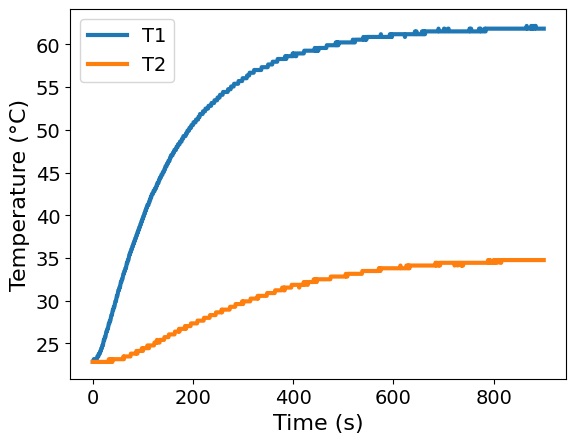

In [3]:
### BEGIN SOLUTION
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')
### END SOLUTION

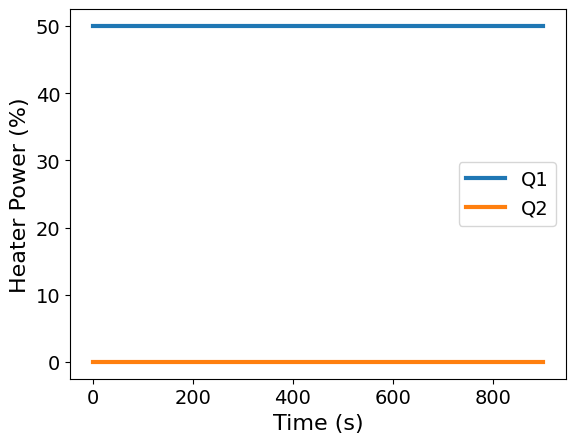

In [4]:
### BEGIN SOLUTION
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')
### END SOLUTION

We'll now store the data in this custom *data class* objective. This is a nice trick to help keep data organized, but it is NOT required to use ParmEst or Pyomo data. Alternatively, we could just use a pandas DataFrame.

In [5]:
tc_data = TC_Lab_data(
    name="Step Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

Our custom data class has a method to export the data as a Pandas Data Frame.

In [6]:
tc_data.to_data_frame().head()

,time,T1,u1,P1,TS1_data,T2,u2,P2,TS2_data,Tamb
0,0.00,22.84,50.0,200,None,22.84,0.0,200,None,22.84
1,1.00,22.84,50.0,200,None,22.84,0.0,200,None,22.84
2,2.01,23.16,50.0,200,None,22.84,0.0,200,None,22.84
3,3.02,22.84,50.0,200,None,22.84,0.0,200,None,22.84
4,4.01,22.84,50.0,200,None,22.84,0.0,200,None,22.84


## Parameter estimation with ParmEst

Now for the main event: performing nonlinear least squares with `ParmEst`.



In [7]:
import pyomo.contrib.parmest.parmest as parmest

# First, we define an Experiment object within parmest
TC_Lab_sine_exp = TC_Lab_experiment(data=tc_data, number_of_states=number_tclab_states)

# Since everything has been labeled properly in the Experiment object, we simply invoke
# parmest's Estimator function to estimate the parameters.
pest = parmest.Estimator([TC_Lab_sine_exp, ], obj_function='SSE', tee=True)

obj, theta = pest.theta_est()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

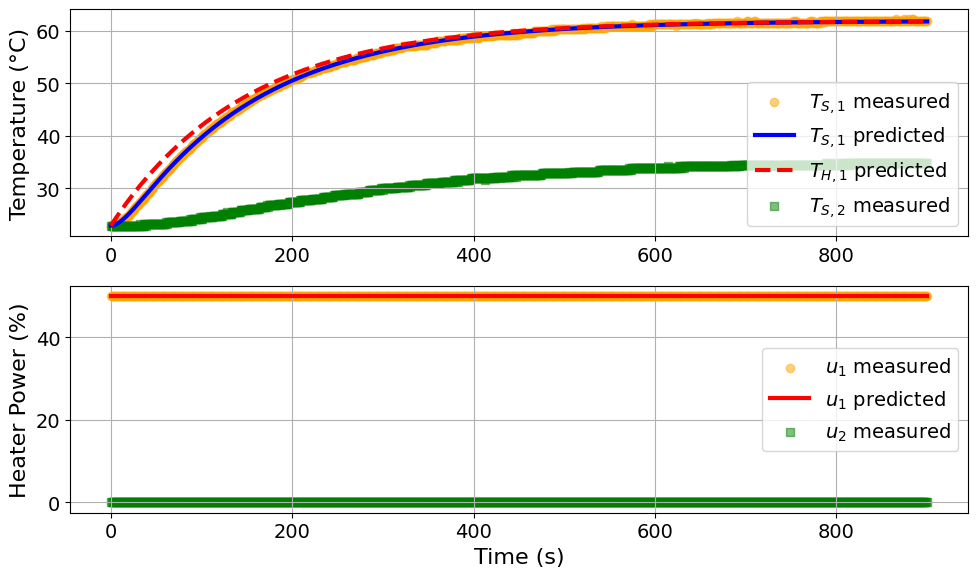

Model parameters:
Ua = 0.041 Watts/degC
Ub = 0.0091 Watts/degC
CpH = 5.9527 Joules/degC
CpS = 0.1387 Joules/degC
 


In [8]:
parmest_regression_results = extract_plot_results(
    tc_data, pest.ef_instance
)

**Discussion**: How do these results compare to our [previous analysis](../notebooks/parmest.ipynb)?